In [24]:
from pathlib import Path
from functools import partial
from abc import ABC, abstractmethod

import json
import random
import colorsys
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from math import sqrt
from itertools import chain
from collections import Counter, defaultdict, OrderedDict

from IPython.display import display, Image
from IPython.core.display import HTML 

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from ml_metrics import quadratic_weighted_kappa, rmse

DATA_HOME = Path('../input')

IS_LOCAL = Path('IS_LOCAL').exists()
LABEL_NUM = 5

DEFAULT = 0
pd.set_option('display.max_rows', 100)

print(f'IS_LOCAL = {IS_LOCAL}')

pd.set_option('display.max_columns', None)
SEED = 7
np.random.seed(SEED)
CATEGORY_SUFFIX = '@c'

IS_LOCAL = True


In [13]:
TORCH="https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl"
!pip install ml_metrics nltk $TORCH torchvision

    100% |████████████████████████████████| 67.1MB 768kB/s ta 0:00:0111
    100% |████████████████████████████████| 71kB 1.1MB/s ta 0:00:011
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [47]:
def greedy_group_k_fold_stratified(X, y, groups, k=5):
    y_counts_per_group = defaultdict(lambda: np.zeros(LABEL_NUM))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(LABEL_NUM))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(LABEL_NUM):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)

    for g, y_counts in sorted(y_counts_per_group.items(), key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [63]:
def by_indices(data, indices):
        if isinstance(data, pd.DataFrame):
            return data.iloc[indices]
        if isinstance(data, list):
            return [data[i] for i in indices]
        return data[indices]     

def run_cv_model(
    name, 
    train_y, train_rescue_ids,
    train_x, train_ids,
    test_x, test_ids, 
    reg_model_factory, qwk_model_factory, k=5
):
    def format_stats(mean: float, std: float) -> str:
        return f'{mean:.3f} ± {std:.3f}'

    def save_predictions(pred_y):
        if IS_LOCAL:
            preds_dir = Path('predictions')
            preds_path = preds_dir / f'{name}.csv'
            checks_num = test_ids
            while preds_path.exists():
                checks_num += 1
                new_file_name = f'{name}-{checks_num}.csv'
                preds_path = preds_dir / new_file_name
            print(f'Saving to path `{preds_path}`')
        else:
            preds_path = 'submission.csv'

        submission = pd.DataFrame({'PetID': test_ids, 'AdoptionSpeed': pred_y.astype(np.int32)})
        submission.to_csv(preds_path, index=False)
    
    def get_formatted_cv_evals(dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores):
        data = []
        indices = []
        for fold_ind, scores in enumerate(zip(
            dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores
        )):
            data.append([f'{s:.3f}' for s in scores])
            indices.append(f'{name} - fold {fold_ind}')
        return pd.DataFrame(data, index=indices, columns=[
            'dev cv rmse', 'val cv rmse', 'dev cv qwk', 'val cv qwk'])
    
    def get_distr(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(5)]

    dev_rmse_scores = []
    dev_qwk_scores = []
    
    val_rmse_scores = []
    val_qwk_scores = []

    pred_train_y_reg = np.zeros(len(train_y))
    pred_test_y_reg = 0
    
    models = []
    qwk_models = []
    
#     splits = StratifiedKFold(n_splits=k, random_state=7, shuffle=True).split(train_x, train_y)
#     splits = GroupKFold(n_splits=k).split(train_x, train_y, groups=train_rescue_ids)
#     splits = group_k_fold_stratified(train_x, train_y, groups=train_rescue_ids, k=5)
    splits = greedy_group_k_fold_stratified(train_x, train_y, groups=train_rescue_ids, k=5)

    for fold, (dev_indices, val_indices) in enumerate(splits):
        g1 = set(by_indices(train_rescue_ids, dev_indices))
        g2 = set(by_indices(train_rescue_ids, val_indices))
        
        assert len(g1 & g2) == 0
        
        dev_x, val_x = by_indices(train_x, dev_indices), by_indices(train_x, val_indices)
        dev_y, val_y = by_indices(train_y, dev_indices), by_indices(train_y, val_indices)
        dev_ids, val_ids = by_indices(train_ids, dev_indices), by_indices(train_ids, val_indices)
        
        display(pd.DataFrame([
            [f'{len(dev_y) / len(train_y):.2%}'] + get_distr(dev_y),
            [f'{len(val_y) / len(train_y):.2%}'] + get_distr(val_y)
        ], index=[f'fold {fold}: dev_y', f'fold {fold}: val_y'], 
           columns=['# of examples'] + list(range(5))
        ))

        model = reg_model_factory()
        model.fit(dev_x, dev_ids, dev_y, val_x, val_ids, val_y)
        
        pred_dev_y_reg = model.predict(dev_x, dev_ids)
        dev_rmse_scores.append(rmse(dev_y, pred_dev_y_reg))
        
        pred_val_y_reg = model.predict(val_x, val_ids)
        val_rmse_scores.append(rmse(val_y, pred_val_y_reg))

        qwk_model = qwk_model_factory()
        qwk_model.fit(pred_dev_y_reg, dev_ids, dev_y, pred_val_y_reg, val_ids, val_y)
        
        pred_dev_y = qwk_model.predict(pred_dev_y_reg, dev_ids)
        dev_qwk_scores.append(quadratic_weighted_kappa(dev_y, pred_dev_y))
        
        pred_val_y = qwk_model.predict(pred_val_y_reg, val_ids)
        val_qwk_scores.append(quadratic_weighted_kappa(val_y, pred_val_y))

        pred_train_y_reg[val_indices] = pred_val_y_reg
        pred_test_y_reg += model.predict(test_x)
        
        models.append(model)
        qwk_models.append(qwk_model)

    pred_test_y_reg /= k

    qwk_model = qwk_model_factory()
    qwk_model = qwk_model.from_models(qwk_models)

    pred_train_y = qwk_model.predict(pred_train_y_reg, train_ids)
    train_qwk = quadratic_weighted_kappa(train_y, pred_train_y)
    
    display(get_formatted_cv_evals(dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores))

    display(pd.DataFrame([[
        '',
        f'{np.mean(dev_rmse_scores):.3f}',
        f'{np.std(dev_rmse_scores):.3f}',
        f'{np.mean(val_rmse_scores):.3f}',
        f'{np.std(val_rmse_scores):.3f}',
        f'{np.mean(dev_qwk_scores):.3f}',
        f'{np.std(dev_qwk_scores):.3f}',
        f'{np.mean(val_qwk_scores):.3f}',
        f'{np.std(val_qwk_scores):.3f}',
        f'{train_qwk:.3f}'
    ]], index=[name], columns=[
        'params', 
        'dev cv rmse (avg)', 'dev cv rmse (std)', 'val cv rmse (avg)', 'val cv rmse (std)',
        'dev cv qwk (avg)', 'dev cv qwk (std)', 'val cv qwk (avg)', 'val cv qwk (std)', 
        'train set qwk']))
    
    pred_test_y = qwk_model.predict(pred_test_y_reg, test_ids)
    
    display(pd.DataFrame([
        get_distr(train_y),
        get_distr(pred_train_y),
        get_distr(pred_test_y),
    ], index=['train_y', 'pred_train_y', 'pred_test_y'], columns=list(range(5))))
    
    save_predictions(pred_test_y)
    
    conf_matrix = pd.DataFrame(
        sk_cmatrix(train_y, pred_train_y), index=list(range(5)), columns=list(range(5)))
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d')
    ax.set_xlabel('y_pred')
    ax.set_ylabel('y_true')
    display(ax)
    
    return OrderedDict([
        ('models',            models),
        ('qwk_models',        qwk_models),
        ('pred_train_y_reg',  pred_train_y_reg),
        ('pred_train_y',      pred_train_y),
        ('pred_test_y_reg',   pred_test_y_reg),
        ('pred_test_y',       pred_test_y),
    ])


def display_train_example(idx):
    data_id = train_ids[idx]
    data = train_x.iloc[idx].to_dict()
    df = pd.DataFrame([
        ('Type', {1: 'dog', 2: 'cat'}[data['Type']]),
        ('Name', data['Name']),
        ('Age', data['Age']),
        ('Breed1', breed_labels_map.get(data['Breed1'], "MISSING")),
        ('Breed2', breed_labels_map.get(data['Breed2'], "MISSING")),
        ('Gender', {1: 'Male', 2: 'Female', 3: 'Mixed'}[data['Gender']]),
        ('Color1', color_labels_map.get(data['Color1'], "MISSING")),
        ('Color2', color_labels_map.get(data['Color2'], "MISSING")),
        ('MaturitySize', {1: 'small', 2: 'medium', 3: 'large', 4: 'extra large', 0: 'NOT SPECIFIED'}[data['MaturitySize']]),
        ('FurLength', {1: 'short', 2: 'medium', 3: 'Long', 0: 'NOT SPECIFIED'}[data['FurLength']]),
        ('Vaccinated', {1: 'Yes', 2: 'No', 3: 'Not sure'}[data['Vaccinated']]),
        ('Dewormed', {1: 'Yes', 2: 'No', 3: 'Not sure'}[data['Dewormed']]),
        ('Sterilized', {1: 'Yes', 2: 'No', 3: 'Not sure'}[data['Sterilized']]),
        ('Health', {1: 'Healthy', 2: 'Minor', 3: 'Serious', 0: 'NOT SPECIFIED'}[data['Health']]),
        ('Quantity', data['Quantity']),
        ('Fee', data['Fee']),
        ('State', state_labels_map[data['State']]),
        ('VideoAmt', data['VideoAmt']),
        ('PhotoAmt', data['PhotoAmt']),
    ], columns=['attribute', 'value'])
    df = df.set_index('attribute')
    display(df)
    display(data['Description'])
    for i in range(1, int(data['PhotoAmt']) + 1):
        display(Image(filename=str(DATA_HOME / 'train_images' / f'{data_id}-{i}.jpg')))

def show_random_example(pred_train_y, actual_label, pred_label, n=10):
    indices = [idx for idx, (y, pred_y) in enumerate(zip(train_y, pred_train_y)) 
               if y == actual_label and pred_y == pred_label]
    display_train_example(random.choice(indices))

    
def derive_feature_names(transformer):
    if isinstance(transformer, Pipeline):
        _, t = transformer.steps[-1]
        return derive_feature_names(t)
    elif isinstance(transformer, FeatureUnion):
        return [f'{n}_{f}' for n, t in transformer.transformer_list for f in derive_feature_names(t)]
    try:
        return transformer.get_feature_names()
    except AttributeError:
        raise AttributeError(f'Transformer {transformer} does not have `get_feature_names` function')


def apply_pipeline(pipeline, train_x, test_x):
    train_f = pipeline.fit_transform(train_x)
    test_f = pipeline.transform(test_x)
    feature_names = derive_feature_names(pipeline)
    return train_f, test_f, pipeline, feature_names


def get_categorical_indices(feature_names):
    return [i for i, name in enumerate(feature_names) if name.endswith(CATEGORY_SUFFIX)]

In [49]:
class ColumnSelector(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, cat_cols, num_cols):
        self._cat_cols = cat_cols
        self._num_cols = num_cols
    
    def fit(self, *_):
        return self
    
    def transform(self, X, *_):
        res_X = X[self._cat_cols + self._num_cols]
        res_X.loc[:, self._cat_cols] = X[self._cat_cols].astype('category')
        return res_X


class Mapper(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, func):
        self._func = func
    
    def fit(self, *_):
        return self
    
    def transform(self, X, *_):
        return self._func(X)


class Features(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, transformer, prefix='', categorical=False, feature_names=None):
        self._transformer = transformer
        self._prefix = prefix
        self._categorical_suffix = CATEGORY_SUFFIX if categorical else ''
        if feature_names is not None:
            self._feature_names = self._format_feature_names(feature_names)
            self._features_num = len(feature_names)
        else:
            self._feature_names = None
            self._features_num = None
    
    def fit(self, *args, **kwds):
        self._transformer.fit(*args, **kwds)
        return self
    
    def transform(self, *args, **kwds):
        result = self._transformer.transform(*args, **kwds)
        
        if self._features_num is None:
            self._features_num = self._get_size(result)
        else:
            assert self._features_num == self._get_size(result)
        return result

    def get_feature_names(self):
        if not self._feature_names:
            try:
                fns = self._transformer.get_feature_names()
            except AttributeError:
                if self._features_num is None:
                    raise ValueError('Feature names cannot be taken before calling transform')
                fns = range(self._features_num)
            self._feature_names = self._format_feature_names(fns)
        return self._feature_names
    
    def _format_feature_names(self, feature_names):
        return [f'{self._prefix}{i}{self._categorical_suffix}' for i in feature_names]
    
    def _get_size(self, x):
        if isinstance(x, list) or isinstance(x, pd.Series):
            return len(x[0])
        return x.shape[1]


def Cols(cols, categorical=False):
    return Features(
        Mapper(lambda x: list(zip(*[x[c] for c in cols]))),
        categorical=categorical,
        feature_names=cols
    )

# def CatCols(cols):
#     return Cols(cols, True)


class CatCols(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, cols, use_label_encoder=False):
        self._cols = cols
        self._feature_names = [f'{c}{CATEGORY_SUFFIX}' for c in cols]
        
        self._encoders = None
        if use_label_encoder:
            self._encoders = defaultdict(dict)
            
    def fit(self, X, *args, **kwds):        
        return self
    
    def transform(self, X, *args, **kwds):
        col_values = []
        for c in self._cols:
            vals = X[c]
            if self._encoders is not None:
                vals = [self._encode_value(c, v) for v in vals]
            col_values.append(vals)
        return list(zip(*col_values))

    def get_feature_names(self):
        return self._feature_names
    
    def _encode_value(self, col, value):
        try:
            result = self._encoders[col][value]
        except KeyError:
            result = len(self._encoders[col])
            self._encoders[col][value] = result
        return result
        

class Predictor(ABC):
    @abstractmethod
    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        pass

    @abstractmethod
    def predict(self, x, ids):
        pass


class QwkPredictor(Predictor):
    @abstractmethod
    def from_models(self, models):
        pass

In [50]:
class LgbmPredictor(Predictor):
    def __init__(self, params, f_names):
        params = params.copy()
        self.num_rounds = params.pop('num_rounds')
        self.verbose_eval = params.pop('verbose_eval')
        self.early_stop = params.pop('early_stop', None)

        self.params = dict(params)
        self.params['seed'] = SEED
        
        self.model = None
        self._cat_indices = get_categorical_indices(f_names)

    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        print(train_x.shape)
        print(valid_x.shape)
        d_train = lgb.Dataset(train_x, label=train_y, categorical_feature=self._cat_indices)
        d_valid = lgb.Dataset(valid_x, label=valid_y, categorical_feature=self._cat_indices)

        watch_list = [d_train, d_valid]

        self.model = lgb.train(
            self.params,
            train_set=d_train,
            num_boost_round=self.num_rounds,
            valid_sets=watch_list,
            verbose_eval=self.verbose_eval,
            early_stopping_rounds=self.early_stop
        )

    def predict(self, x, ids):
        return self.model.predict(x, num_iteration=self.model.best_iteration)


class QwkOptimizer(QwkPredictor):
    def __init__(self):
        self.coefficient = None

    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        assert len(train_x) == len(train_y)
        assert len(valid_x) == len(valid_y)
        loss_partial = partial(self._kappa_loss, x=train_x, y=train_y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coefficient = sp.optimize.minimize(
            loss_partial, initial_coef, method='nelder-mead')['x']
        print(f'Coefficients after fitting are {self.coefficient}')

    def predict(self, x, ids):
        return self._apply_coeffs(self.coefficient, x)

    def from_models(self, models):
        self.coefficient = np.mean([m.coefficient for m in models], axis=0)
        print(f'Average coefficients taken from models are {self.coefficient}')
        return self

    def _kappa_loss(self, coeffs, x, y):
        x_p = self._apply_coeffs(coeffs, x)
        return -quadratic_weighted_kappa(y, x_p)

    def _apply_coeffs(self, coeffs, x):
        x_p = np.copy(x)
        for i, pred in enumerate(x_p):
            if pred < coeffs[0]:
                x_p[i] = 0
            elif coeffs[0] <= pred < coeffs[1]:
                x_p[i] = 1
            elif coeffs[1] <= pred < coeffs[2]:
                x_p[i] = 2
            elif coeffs[2] <= pred < coeffs[3]:
                x_p[i] = 3
            else:
                x_p[i] = 4
        return x_p

In [159]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook as tqdm

from PIL import Image


class PetPyTorchDataset(Dataset):
    def __init__(self, pet_ids, train, y=None, transform=None):
        self.transform = transforms.Compose(transform or [])
        
        image_dir = DATA_HOME / ('train_images' if train else 'test_images')
        self.image_paths, data_indices = self._get_image_paths(image_dir, pet_ids)
        
        if y is not None:
            self.y = np.array(by_indices(y, data_indices), dtype=np.float32)
        else: 
            self.y = np.full(len(data_indices), -1, dtype=np.float32)
            
        self.pet_ids = by_indices(pet_ids, data_indices)
        
    def _get_image_paths(self, image_dir, pet_ids, only_first_image=True):
        def get_image_idx(p):
            return int(str(p).rsplit('-')[1].split('.')[0])
        def get_pet_id(p):
            return str(p).rsplit('/', 1)[1].split('-')[0]
        
        image_paths_per_pet_id = defaultdict(list)
        for p in image_dir.iterdir():
            image_paths_per_pet_id[get_pet_id(p)].append(p)
        
        image_paths = []
        data_indices = []
        for p_index, p_id in enumerate(pet_ids):
            pet_image_paths = sorted(image_paths_per_pet_id[p_id], key=get_image_idx)
            if len(pet_image_paths) > 0 and only_first_image:
                pet_image_paths = [pet_image_paths[0]]
            image_paths.extend(pet_image_paths)
            data_indices.extend([p_index] * len(pet_image_paths))
        
        return image_paths, data_indices
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(image), self.y[idx], self.pet_ids[idx]


class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = models.resnet34(pretrained=True)
        last_resnet_size = self.base.fc.in_features
        print(f'Last resnet layer is: {last_resnet_size}')
        
        self.fc = nn.Linear(last_resnet_size, 1)

    def forward(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)

        x = self.base.avgpool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

    
class PyTorchModel(Predictor):
    def __init__(self, net, lr, epochs, verbose=True):
        self.net = net
        self.lr = lr
        self.epochs = epochs
        self.verbose = verbose
        
        self.batch_size = 32
        
        self.transforms = [
            transforms.Resize((128, 128)),
#             transforms.CenterCrop(224),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
        
        device_type = "cuda:0" if torch.cuda.is_available() else "cpu"
        print(f'Device `{device_type}` will be used')
        self.device = torch.device(device_type)
        self.net.to(self.device)
    
    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        print('Loading train images')
        train_ds = PetPyTorchDataset(train_ids, train=True, y=train_y, transform=self.transforms)
        print('Loading valid images')
        valid_ds = PetPyTorchDataset(valid_ids, train=True, y=valid_y, transform=self.transforms)
        
        loader = DataLoader(train_ds, shuffle=True, batch_size=self.batch_size)
        
        loss_func = RMSELoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        
        best_valid_loss = float('inf')
        best_net_state = None
        
        for epoch in range(self.epochs):
            for x, y, pet_ids in tqdm(loader, desc=f'Training (epoch={epoch})'):
                x = x.to(self.device)
                y = y.to(self.device)
                y_pred = self.net(x)

                loss = loss_func(y_pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            with torch.no_grad():
                valid_y_pred, valid_y = self._interference(valid_ds)
                valid_loss = loss_func(valid_y_pred, valid_y)

                loss_val = loss.item()
                valid_loss_val = valid_loss.item()

                if verbose:
                    print(f'Epoch={epoch}, '
                          f'Update={updates_num}, '
                          f'Batch loss={loss_val}, '
                          f'Valid loss={valid_loss_val}')

                if valid_loss_val < best_valid_loss:
                    best_valid_loss = valid_loss_val
                    best_net_state = self.net.state_dict()

        self.net.load_state_dict(best_net_state)
    
    def _interference(self, ds):
        with torch.no_grad():
            x = self._urls_to_tensor(urls)
            loader = DataLoader(ds, shuffle=False, batch_size=self.batch_size)

            preds_per_batch = []
            y = []
            pet_ids = []
            for batch_x, batch_y, batch_pet_ids in loader:
                x = x.to(self.device)
                preds = self.net(x)
                preds_per_batch.append(preds)
                y.extend(batch_y)
                pet_ids.extend(batch_pet_ids)
            return torch.cat(preds_per_batch), y, pet_ids

    def predict(self, x, ids):
        ds = PetPyTorchDataset(ids, train=False, transform=self.transforms)
        y_pred, _, inf_ids = self._interference(ds)
        y_pred = y_pred.squeeze(1).cpu().numpy()
        
        preds_per_pet_id = defaultdict(list)
        for pred, pet_id in zip(y_pred, inf_ids):
            preds_per_pet_id[pet_id].append(pred)
        assert(all(map(lambda xs: len(xs) == 1, preds_per_pet_id.values())))
        
        return [preds_per_pet_id[pet_id] for pet_id in ids]

In [ ]:
results_nn = run_cv_model(
    'lgbm', 
    train_y, train_x['RescuerID'], 
    train_f, train_ids, 
    test_f, test_ids, 
    lambda: PyTorchModel(ResNet(), lr=0.01, epochs=10), lambda: QwkOptimizer()
)

In [144]:
def read_data(data_path, shuffle=False):
    X = pd.read_csv(data_path)
    if shuffle:
        X = X.sample(frac=1, random_seed=SEED).reset_index(drop=True)
    try:
        y = list(X.AdoptionSpeed)
    except AttributeError:
        y = None
    ids = list(X.PetID)
    X.drop(['PetID', 'AdoptionSpeed'], axis=1, inplace=True, errors='ignore')
    return X, y, ids


def read_metadata(pet_ids_list, metadata_dir):
    def get_idx(path):
        return int(str(path).rsplit('-', 1)[1].split('.')[0])
    
    def get_sorted_photos_by_idx(paths):
        return sorted((get_idx(p), p) for p in paths)
    
    def extract_label_annotations(metadata_dict):
        def by_score(xs): return xs[1]
        label_annotations = []
        for annotation in metadata_dict.get('labelAnnotations', []):
            desc = annotation['mid']
            score = annotation['score']
            label_annotations.append((desc, score))
        return sorted(label_annotations, key=by_score, reverse=True)
    
    def extract_dominant_colors(metadata_dict):
        def by_score(xs): return xs[3]
        dominant_colors = []
        colors = metadata_dict.get('imagePropertiesAnnotation', {}).get('dominantColors', {}).get('colors', [])
        for color_obj in colors:
            rgb_obj = color_obj['color']
            red = rgb_obj.get('red', 0) / 255
            green = rgb_obj.get('green', 0) / 255
            blue = rgb_obj.get('blue', 0) / 255
            score = color_obj['score']
            pixel_fraction = color_obj['pixelFraction']
            dominant_colors.append(
                (red, green, blue, score, pixel_fraction)
            )
        return sorted(dominant_colors, key=by_score, reverse=True)
    
    metadata_dir = Path(metadata_dir)
    for pet_id in pet_ids_list:
        pet_metadata_paths = metadata_dir.glob(f'{pet_id}-1.json')
        
        pet_label_annotations = []
        pet_dominant_colors = []
        
        for idx, metadata_path in get_sorted_photos_by_idx(pet_metadata_paths):
            with metadata_path.open() as in_file:
                metadata_dict = json.load(in_file)
                
                pet_label_annotations.append(extract_label_annotations(metadata_dict))
                pet_dominant_colors.append(extract_dominant_colors(metadata_dict))
        
        yield pet_label_annotations, pet_dominant_colors

In [145]:
def read_sentiment_data(pet_ids_list, sentiment_dir):
    sentiment_dir = Path(sentiment_dir)
    missed_sentiments = 0
    for pet_id in pet_ids_list:
        sentiment_data_path = sentiment_dir / f'{pet_id}.json'
        
        if not sentiment_data_path.exists():
            yield [], {}, DEFAULT, DEFAULT
            missed_sentiments += 1
        else:
            with sentiment_data_path.open() as in_file:
                sentiment_data = json.load(in_file)

                sentence_sents = [(obj['sentiment']['magnitude'], obj['sentiment']['score']) 
                                       for obj in sentiment_data['sentences']]
                entity_sents = {obj['name'].lower().strip(): obj['salience']
                            for obj in sentiment_data['entities']}
                doc_sent_magnitude = sentiment_data['documentSentiment']['magnitude']
                doc_sent_score = sentiment_data['documentSentiment']['score']

                yield sentence_sents, entity_sents, (doc_sent_magnitude, doc_sent_score)
    print(f'Missed sentiment files for {missed_sentiments} pet ids')

def pet_data_assigner(X, data_reader, **mappers):
    extacted_data = defaultdict(list)
    data_num = 0
    errors_per_mapper = Counter()
    for data in data_reader:
        for k, (map_func, default_val) in mappers.items():
            try:
                map_result = map_func(*data)
            except:
                map_result = default_val
                errors_per_mapper[k] += 1
            extacted_data[k].append(map_result)
        data_num += 1 
    
    for k, errors_num in errors_per_mapper.items():
        if errors_num > 0: 
            print(f'There were {errors_num} errors ({int(errors_num * 100 / data_num)}%) for mapper {k}')
    
    for k, data in extacted_data.items():
        X[k] = data

        
def train_test_data_assigner(train_data_reader, test_data_reader, **mapper_info):
    mappers = {}
    col_assignments = []
    for k, (mapper_func, default, add_to) in mapper_info.items():
        mappers[k] = (mapper_func, default)
        if add_to is not None:
            col_assignments.append((add_to, k))
    
    pet_data_assigner(
        train_x, train_data_reader, **mappers
    )
    pet_data_assigner(
        test_x, test_data_reader, **mappers
    )
    
    for cols_list, col in col_assignments:
        if col not in cols_list:
            cols_list.append(col)
        
def m(mapper_func, *, default, add_to=None):
    return mapper_func, default, add_to

In [146]:
train_x, train_y, train_ids = read_data(DATA_HOME / 'train' / 'train.csv')
test_x, test_y, test_ids = read_data(DATA_HOME / 'test' / 'test.csv')

display(train_x.shape)
display(test_x.shape)

special_cols = ['RescuerID']
text_cols = ['Name', 'Description']
num_cols = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'MaturitySize', 'FurLength', 'Health']
cat_cols = list(set(train_x.columns) - set(text_cols) - set(num_cols) - set(special_cols))

breed_labels_map = {row.BreedID: row.BreedName 
                   for _, row in pd.read_csv(DATA_HOME / 'breed_labels.csv').iterrows()}

state_labels_map = {row.StateID: row.StateName 
                   for _, row in pd.read_csv(DATA_HOME / 'state_labels.csv').iterrows()}

color_labels_map = {row.ColorID: row.ColorName 
                   for _, row in pd.read_csv(DATA_HOME / 'color_labels.csv').iterrows()}

# breed_rating = json.loads((DATA_HOME / 'breed_rating.json').read_text())

display(len(breed_labels_map))

print(special_cols)
print(text_cols)
print(num_cols)
print(cat_cols)

(14993, 22)

(3948, 22)

307

['RescuerID']
['Name', 'Description']
['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'MaturitySize', 'FurLength', 'Health']
['Breed2', 'Sterilized', 'Color1', 'State', 'Dewormed', 'Vaccinated', 'Color3', 'Breed1', 'Type', 'Color2', 'Gender']


In [262]:
train_test_data_assigner(
    read_sentiment_data(train_ids, DATA_HOME / 'train_sentiment'),
    read_sentiment_data(test_ids, DATA_HOME / 'test_sentiment'),
    first_sentence_magnitude=     m(lambda ss, es, ds: ss[0][0], default=DEFAULT, add_to=num_cols),
    first_sentence_score=         m(lambda ss, es, ds: ss[0][1], default=DEFAULT, add_to=num_cols),
    second_sentence_magnitude=    m(lambda ss, es, ds: ss[1][0], default=DEFAULT, add_to=num_cols),
    second_sentence_score=        m(lambda ss, es, ds: ss[1][1], default=DEFAULT, add_to=num_cols),
    third_sentence_magnitude=     m(lambda ss, es, ds: ss[2][0], default=DEFAULT, add_to=num_cols),
    third_sentence_score=         m(lambda ss, es, ds: ss[2][1], default=DEFAULT, add_to=num_cols),
    mean_sentence_magnitude=      m(lambda ss, es, ds: np.mean([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    std_sentence_magnitude=       m(lambda ss, es, ds: np.std([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sum_sentence_magnitude=       m(lambda ss, es, ds: np.sum([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    mean_sentence_score=          m(lambda ss, es, ds: np.mean([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    std_sentence_score=           m(lambda ss, es, ds: np.std([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sum_sentence_score=           m(lambda ss, es, ds: np.sum([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_count=               m(lambda ss, es, ds: len(ss), default=DEFAULT, add_to=num_cols),
    entity_sents=                 m(lambda ss, es, ds: es, default={}),
    doc_sent_magnitude=           m(lambda ss, es, ds: ds[0], default=DEFAULT, add_to=num_cols),
    doc_sent_score=               m(lambda ss, es, ds: ds[1], default=DEFAULT, add_to=num_cols),
)

Missed sentiment files for 551 pet ids
There were 5074 errors (33%) for mapper third_sentence_magnitude
There were 5074 errors (33%) for mapper third_sentence_score
There were 3161 errors (21%) for mapper second_sentence_magnitude
There were 3161 errors (21%) for mapper second_sentence_score
There were 551 errors (3%) for mapper first_sentence_magnitude
There were 551 errors (3%) for mapper first_sentence_score
There were 551 errors (3%) for mapper mean_sentence_magnitude
There were 551 errors (3%) for mapper std_sentence_magnitude
There were 551 errors (3%) for mapper sum_sentence_magnitude
There were 551 errors (3%) for mapper mean_sentence_score
There were 551 errors (3%) for mapper std_sentence_score
There were 551 errors (3%) for mapper sum_sentence_score
There were 551 errors (3%) for mapper sentence_count
There were 551 errors (3%) for mapper entity_sents
There were 551 errors (3%) for mapper doc_sent_magnitude
There were 551 errors (3%) for mapper doc_sent_score
Missed sentimen

In [263]:
# train_test_data_assigner(
#     read_metadata(train_ids, DATA_HOME / 'train_metadata'),
#     read_metadata(test_ids, DATA_HOME / 'test_metadata'),
#     first_image_label_annotations=     m(lambda la, dm: dict(la[0]), default={}),
#     second_image_label_annotations=     m(lambda la, dm: dict(la[1]), default={}),
#     third_image_label_annotations=     m(lambda la, dm: dict(la[2]), default={}),
#     first_image_color_annotations=     m(lambda la, dm: dict(la[0]), default={}),
# )

In [55]:
class TextFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, prefix=''):
        self._prefix = prefix
    
    def transform(self, texts, *_):
        return [self._text_features(t) for t in texts]
    
    def _text_features(self, text):
        tokens = nltk.word_tokenize(text)
        token_sizes = list(map(len, tokens))
        
        return [
            len(text),
            len(tokens),
            min(token_sizes) if token_sizes else DEFAULT,
            max(token_sizes) if token_sizes else DEFAULT,
            sum(token_sizes) if token_sizes else DEFAULT,
            np.mean(token_sizes) if token_sizes else DEFAULT,
            np.std(token_sizes) if token_sizes else DEFAULT,
        ]

    def fit(self, *_):
        return self
    
    def get_feature_names(self):
        return [f'{self._prefix}{n}' for n in [
            'text_len', 'tokens_num', 'min_token_size', 'max_token_size', 'sum_token_size', 
            'mean_token_size', 'std_token_size']]

In [ ]:
# nltk.download('stopwords')

# LANG = 'english'
# stemmer = nltk.stem.SnowballStemmer(LANG)
# stopwords = stopwords.words('english')

# def tokenize(text, language=LANG):
#     return [w for w in word_tokenize(text.lower(), language=language) if w.isalnum()]

# def stemmed_words(words):
#     return [stemmer.stem(w) for w in words]

# def ngrams(tokens, min_n, max_n):
#     if max_n != 1:
#         original_tokens = tokens
#         if min_n == 1:
#             # no need to do any slicing for unigrams
#             # just iterate through the original tokens
#             tokens = list(original_tokens)
#             min_n += 1
#         else:
#             tokens = []

#         n_original_tokens = len(original_tokens)

#         # bind method outside of loop to reduce overhead
#         tokens_append = tokens.append
#         space_join = " ".join

#         for n in range(min_n, min(max_n + 1, n_original_tokens + 1)):
#             for i in range(n_original_tokens - n + 1):
#                 tokens_append(space_join(original_tokens[i: i + n]))
#     return tokens


# def nltk_analyzer(text, min_n, max_n):
#     tokens = [t for t in tokenize(text) if t not in stopwords]
#     return ngrams(stemmed_words(text), min_n, max_n)

In [56]:
def explode(df, col, fillna=None):
    ret = None
    
    col_name = col if isinstance(col, str) else '_'.join(col)
    
    new_cols = pd.DataFrame(({f'{col_name}_{k}': v for k, v in d.items()} 
                             for idx, d in df[col].iteritems()))
    if fillna is not None:
        new_cols = new_cols.fillna(fillna)
    new_cols.index = df.index
    
    ret = pd.concat([df, new_cols], axis=1)
    del ret[col]
    return ret

In [57]:
class RescuerFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, num_cols, cat_cols, rescued_id_col='RescuerID'):
        self._num_cols = num_cols
        self._cat_cols = cat_cols
        self._rescued_id_col = rescued_id_col
        
        self.columns = None
    
    def transform(self, df, *_):
        result = self._extract_rescuer_features(df)
        for c in self.columns:
            if c not in result.columns:
                result[c] = np.full(df.shape[0], DEFAULT)
        return result[self.columns]
    
    def fit(self, df, *_):
        df = self._extract_rescuer_features(df)
        display(df)
        self.columns = df.columns
        
        return self
    
    def fit_transform(self, df, *_):
        df = self._extract_rescuer_features(df)
        self.columns = df.columns
        
        return df
    
    def get_feature_names(self):
        if self.columns is None:
            raise ValueError('RescuerFeatures was not fitted')
        return self.columns
    
    def _extract_rescuer_features(self, df):
        def num_col_features(values):
            return dict(
                min=min(values) if len(values) > 0 else DEFAULT,
                max=max(values) if len(values) > 0 else DEFAULT,
                sum=sum(values) if len(values) > 0 else DEFAULT,
                mean=np.mean(values) if len(values) > 0 else DEFAULT,
                std=np.std(values) if len(values) > 0 else DEFAULT,
            )
        
        def cat_col_features(values):
            return Counter(values)
        
        agg_operations = defaultdict(list)
        for c in self._num_cols:
            agg_operations[c].append(num_col_features)
        for c in self._cat_cols:
            agg_operations[c].append(cat_col_features)
        agg_operations[self._rescued_id_col].append('size')
            
        by_rescuer_id = df.groupby(self._rescued_id_col).agg(agg_operations)
        for outer_c, inner_c in by_rescuer_id.columns:
            if inner_c in {'num_col_features', 'cat_col_features'}:
                by_rescuer_id = explode(by_rescuer_id, (outer_c, inner_c), DEFAULT)
        by_rescuer_id.columns = [c if isinstance(c, str) else '_'.join(c) 
                                 for c in by_rescuer_id.columns]
        
        result = df[[self._rescued_id_col]].merge(
            by_rescuer_id, how='outer', left_on=self._rescued_id_col, right_index=True
        ).sort_index()
        result.drop(self._rescued_id_col, axis=1, inplace=True)
        return result

In [59]:
train_f, test_f, p, f_names = apply_pipeline(make_pipeline(
    FeatureUnion([
#         ('desc_tokenizing', make_pipeline(
#             Mapper(lambda x: list(x.Description.fillna(''))),
#             CountVectorizer(
#                 analyzer='word',
#                 ngram_range=(1, 3),
#                 dtype=np.float32
#             ),
#             FeatureUnion([
#                 ('svd', Features(TruncatedSVD(n_components=128, random_state=SEED))),
#                 ('nmf', Features(NMF(n_components=128, random_state=SEED)))
#             ])
#         )),
        ('desc_text_fs', make_pipeline(
            Mapper(lambda x: list(x.Description.fillna(''))),
            TextFeatures('desc_')
        )),
#         ('name_text_fs', make_pipeline(
#             Mapper(lambda x: list(x.Name.fillna(''))),
#             TextFeatures('name_')
#         )),
#         ('num_cols', Cols(num_cols)),
#         ('cat_cols', CatCols(cat_cols, use_label_encoder=True)),
#         ('rescuer_fs', make_pipeline(
#             RescuerFeatures(num_cols=num_cols, cat_cols=cat_cols),
# #             FeatureUnion([
# #                 Features(TruncatedSVD(n_components=16, random_state=SEED)),
# #                 Features(NMF(n_components=16, random_state=SEED))
# #             ])
#         )),
# #         make_pipeline(
# #             Mapper(lambda x: x.first_image_label_annotations),
# #             DictVectorizer()
# #         ),
#         ('entity_sents', make_pipeline(
#             Mapper(lambda x: x.entity_sents),
#             DictVectorizer(),
#             FeatureUnion([
#                 ('svd', Features(TruncatedSVD(n_components=8, random_state=SEED))),
#                 ('nmf', Features(NMF(n_components=8, random_state=SEED)))
#             ])
#         )),
#         Features(Mapper(lambda x: list(x.first_image_color_annotations)))
    ])
), train_x, test_x)

In [ ]:
pd.DataFrame(train_f, columns=f_names)

In [ ]:
params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'max_bin': 512,
          'num_leaves': 30,
          'max_depth': 6,
          'min_data_in_leaf': 10,
          'learning_rate': 0.001,
          'bagging_fraction': 0.85,
#           'feature_fraction': 0.8,
#           'min_split_gain': 0.02,
#           'min_child_weight': 0.02,
          'lambda_l2': 0.25,
          'verbosity': 1,
          'early_stop': 2000,
          'verbose_eval': 100,
          'num_rounds': 20000,
         }

results = run_cv_model(
    'lgbm', 
    train_y, train_x['RescuerID'], 
    train_f, train_ids, 
    test_f, test_ids, 
    lambda: LgbmPredictor(params, f_names), lambda: QwkOptimizer()
)

,value
attribute,
Type,dog
Name,Snoopy
Age,10
Breed1,Mixed Breed
Breed2,MISSING
Gender,Male
Color1,Golden
Color2,MISSING
MaturitySize,medium


'Snoopy very cute. He looks better than in the picture. No caging for long hours except for precautionary purposes. Interested adopters pls call Ms.Ooi at.'

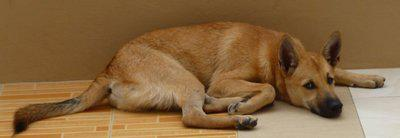

In [207]:
show_random_example(results['pred_train_y'], actual_label=1, pred_label=4)

In [65]:
display(pd.DataFrame(
    Counter(dict(zip(f_names, results['models'][0].model.feature_importance('gain')))).most_common(50)
))

,0,1
0,cat_cols_Breed1@c,515179.702916
1,num_cols_Age,391941.525415
2,cat_cols_Sterilized@c,109767.612425
3,rescuer_fs_Type_cat_col_features_2,52059.698224
4,cat_cols_Breed2@c,51125.398274
5,rescuer_fs_PhotoAmt_num_col_features_sum,47838.754436
6,cat_cols_State@c,45254.057627
7,rescuer_fs_Quantity_num_col_features_mean,40575.521587
8,rescuer_fs_Age_num_col_features_mean,39706.839125
9,rescuer_fs_PhotoAmt_num_col_features_mean,39523.141807
